In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt # need to import matplotlib before pandas
import pandas as pd
from pathlib import Path
from mdlearn.utils import plot_scatter
from typing import List, Dict

from Bio import SeqIO, SeqUtils, SeqRecord
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

/homes/lind/.conda/envs/mdhpipeline/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
def show_scatter(data: np.ndarray, color: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('white')
    ff = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color)
    plt.colorbar(ff)
    plt.show()

In [3]:
ls /homes/mzvyagin/MDH/perlmutter_data/

globalstep2850.fasta           inference-test-embeddings.npy
gpt2_embeddings.tar.gz         inference-train-embeddings.npy
gpt2_generated_embeddings.npy  inference-val-embeddings.npy


In [4]:
#train_embed = np.load("")
val_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/inference-val-embeddings.npy")
test_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/inference-test-embeddings.npy")
generated_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/gpt2_generated_embeddings.npy")

In [5]:
generated_embed.shape

(128, 512, 768)

In [6]:
val_embed.shape

(3664, 512, 768)

In [7]:
# Average residue dimension to get a single embedding per sequence
val_avg = val_embed.mean(axis=1)
test_avg = test_embed.mean(axis=1)
generated_avg = generated_embed.mean(axis=1)

In [8]:
val_avg.shape

(3664, 768)

In [9]:
p = Path("/homes/mzvyagin/MDH/gene_transformer/gene_transformer/data/full_mdh_fasta")

train_seqs = list(SeqIO.parse(p / "train.fasta", "fasta"))
val_seqs = list(SeqIO.parse(p / "val.fasta", "fasta"))
test_seqs = list(SeqIO.parse(p / "test.fasta", "fasta"))
generated_seqs = list(SeqIO.parse("/homes/mzvyagin/MDH/perlmutter_data/globalstep2850.fasta", "fasta"))

# Clip to embedding length
#train_seqs = train_seqs[:len(train_embed)]
val_seqs = val_seqs[:len(val_embed)]
test_seqs = test_seqs[:len(test_embed)]

train_protein_seq = [s.translate(to_stop=True) for s in train_seqs]
val_protein_seq = [s.translate(to_stop=True) for s in val_seqs]
test_protein_seq = [s.translate(to_stop=True) for s in test_seqs]
generated_protein_seqs = [s.translate(to_stop=True) for s in generated_seqs]

/homes/lind/.conda/envs/mdhpipeline/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [10]:
test_protein_seq[0]

SeqRecord(seq=Seq('MKVAVLGAAGGIGQALALLLKTQLPAGSKLSLYDIAPVTPGVAVDLSHIPTDVE...FVK'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [11]:
# Sequence metrics (scalar value per sequence)

def gc_content(seqs):
    return [SeqUtils.GC(rec.seq) for rec in seqs]

def seq_length(seqs):
    return [len(rec.seq) for rec in seqs]

def molecular_weight(seqs):
    return [SeqUtils.molecular_weight(rec.seq, "protein") for rec in seqs]

def isoelectric_point(seqs):
    return [IsoelectricPoint(seq).pi() for seq in seqs]

train_paint_df = pd.DataFrame({
        "GC": gc_content(train_seqs),
        "SequenceLength": seq_length(train_seqs),
        "MolecularWeight": molecular_weight(train_seqs),
        "IsoelectricPoint": isoelectric_point(train_protein_seq),
})

val_paint_df = pd.DataFrame({
        "GC": gc_content(val_seqs),
        "SequenceLength": seq_length(val_seqs),
        "MolecularWeight": molecular_weight(val_protein_seq),
        "IsoelectricPoint": isoelectric_point(val_protein_seq),
})

test_paint_df = pd.DataFrame({
        "GC": gc_content(test_seqs),
        "SequenceLength": seq_length(test_seqs),
        "MolecularWeight": molecular_weight(test_protein_seq),
        "IsoelectricPoint": isoelectric_point(test_protein_seq),
})

generated_paint_df = pd.DataFrame({
        "GC": gc_content(generated_seqs),
        "SequenceLength": seq_length(generated_seqs),
        "MolecularWeight": molecular_weight(generated_protein_seqs),
        "IsoelectricPoint": isoelectric_point(generated_protein_seqs),
})

In [12]:
train_paint_df.corr()

,GC,SequenceLength,MolecularWeight,IsoelectricPoint
GC,1.000000,0.265624,0.276833,0.047922
SequenceLength,0.265624,1.000000,0.975473,0.254085
MolecularWeight,0.276833,0.975473,1.000000,0.237541
IsoelectricPoint,0.047922,0.254085,0.237541,1.000000


In [13]:
val_paint_df.corr()

,GC,SequenceLength,MolecularWeight,IsoelectricPoint
GC,1.000000,0.260735,0.083411,0.041451
SequenceLength,0.260735,1.000000,0.895989,0.246249
MolecularWeight,0.083411,0.895989,1.000000,0.247115
IsoelectricPoint,0.041451,0.246249,0.247115,1.000000


In [14]:
test_paint_df.corr()

,GC,SequenceLength,MolecularWeight,IsoelectricPoint
GC,1.000000,0.276797,0.108882,0.044267
SequenceLength,0.276797,1.000000,0.935294,0.231844
MolecularWeight,0.108882,0.935294,1.000000,0.264127
IsoelectricPoint,0.044267,0.231844,0.264127,1.000000


In [15]:
generated_paint_df.corr()

,GC,SequenceLength,MolecularWeight,IsoelectricPoint
GC,1.000000,0.754317,0.530526,0.385670
SequenceLength,0.754317,1.000000,0.859658,0.706478
MolecularWeight,0.530526,0.859658,1.000000,0.894860
IsoelectricPoint,0.385670,0.706478,0.894860,1.000000


array([[<AxesSubplot:title={'center':'GC'}>,
        <AxesSubplot:title={'center':'SequenceLength'}>],
       [<AxesSubplot:title={'center':'MolecularWeight'}>,
        <AxesSubplot:title={'center':'IsoelectricPoint'}>]], dtype=object)

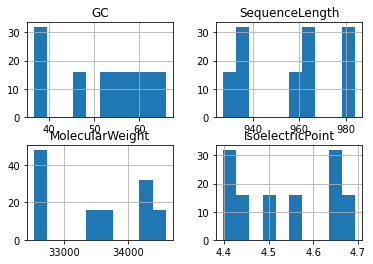

In [16]:
generated_paint_df.hist()

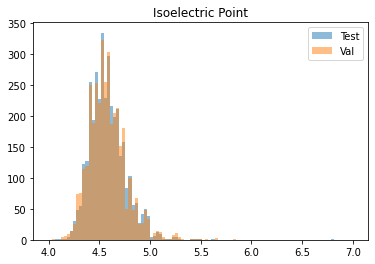

In [17]:
bins = np.linspace(4, 7, 100)

plt.hist(test_paint_df["IsoelectricPoint"], bins, alpha=0.5, label='Test')
plt.hist(val_paint_df["IsoelectricPoint"][:-1], bins, alpha=0.5, label='Val')
plt.legend(loc='upper right')
plt.title("Isoelectric Point")
plt.show()

# Run UMAP

In [20]:
def run_umap(data: np.ndarray):
        
    # attempt to use rapidsai
    from cuml.manifold import UMAP
    
    # to enable consistency of trained embeddings
    model = UMAP(random_state=10)
    
    data_proj = model.fit_transform(data)
    
    return data_proj
    
def plot_umap(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, cmap: str = "plasma"):
    
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    ax2 = df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4)
    plt.show()
    
    return df
    

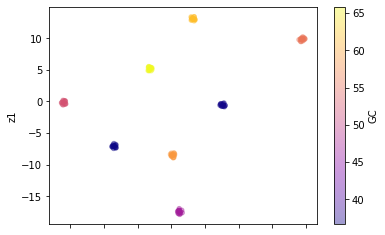

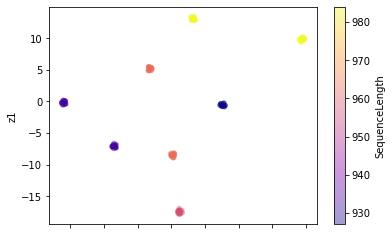

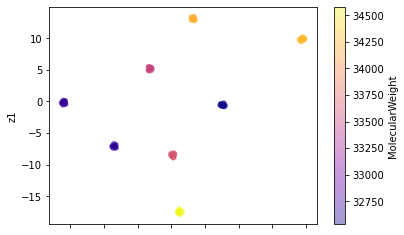

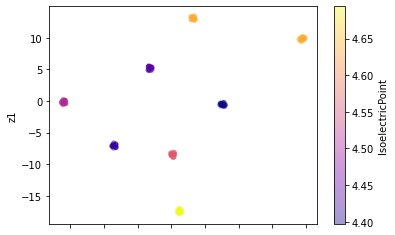

In [21]:
generated_umap = run_umap(generated_avg)
for key in test_paint_df:
    gen_df = plot_umap(generated_umap, generated_paint_df[key], key, cmap="plasma")

# Select cluster prototypes for generated sequences

In [22]:
from sklearn.cluster import KMeans
# Use 8 clusters as seen in UMAP
kmeans = KMeans(n_clusters=8, random_state=0).fit(generated_avg)

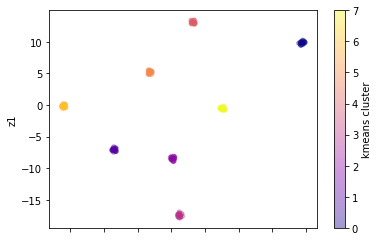

In [24]:
gen_df = plot_umap(generated_umap, kmeans.labels_, "kmeans cluster", cmap="plasma")

In [25]:
generated_avg.shape

(128, 768)

In [26]:
kmeans.cluster_centers_.shape

(8, 768)

In [27]:
def get_cluster_prototypes(generated_avg, kmeans, k: int = 2) -> Dict[int, List[int]]:
    results = {}
    inds = np.arange(len(generated_avg))
    for label in np.unique(kmeans.labels_):
        mask = kmeans.labels_ == label
        generated_inds = inds[mask]
        generated_cluster = generated_avg[mask]
        # Recompute cluster center incase of numerical issues
        # Should be the same as kmeans.cluster_centers_[label]
        center = np.mean(generated_cluster, axis=0).reshape(1, -1)
        dists = np.linalg.norm(center - generated_cluster, axis=1)
        top_k = np.argpartition(dists, kth=k)
        results[label] = generated_inds[top_k[:k]]
    return results

In [28]:
# Pick 2 points in each cluster that are closest to the kmeans cluster centroid
prototypes = get_cluster_prototypes(generated_avg, kmeans)

In [29]:
prototypes

{0: array([36, 68]),
 1: array([29, 61]),
 2: array([121, 105]),
 3: array([ 62, 126]),
 4: array([115,  91]),
 5: array([55, 39]),
 6: array([ 58, 122]),
 7: array([96, 40])}

In [30]:
prototype_seqs = {key: [generated_protein_seqs[ind] for ind in val]  for key, val in prototypes.items()}

In [31]:
record_dir = Path("synthetic_seqeunces")
record_dir.mkdir(exist_ok=True)
for key, seqs in prototype_seqs.items():
    inds = prototypes[key]
    for seq, ind in zip(seqs, inds):
        seq.id = f"MDH_SyntheticSeq_cluster_prototype_{key}_index_{ind}"
        seq.name="MDH_sequence",
        seq.description="synthetic malate dehydrogenase"
        SeqIO.write(seq, record_dir / f"MDH_synthetic_cluster_prototype_{key}_index_{ind}.fasta", "fasta")

# Visualization of Testing Embeddings

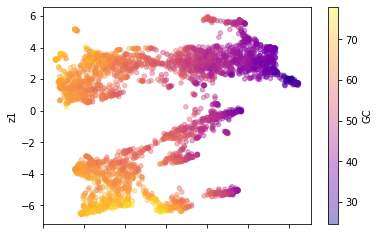

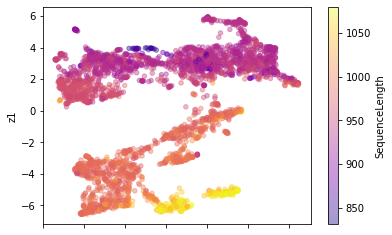

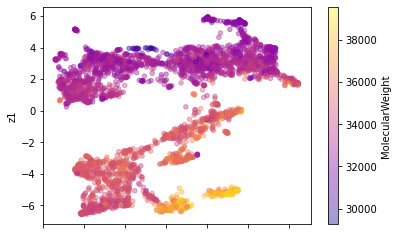

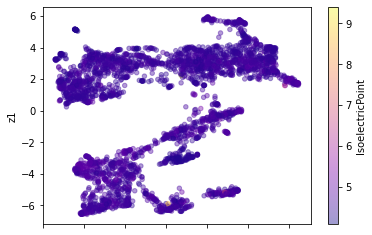

In [33]:
test_umap = run_umap(test_avg)
for key in test_paint_df:
    test_df = plot_umap(test_umap, test_paint_df[key], key, cmap="plasma")

In [34]:
test_umap.shape

(3656, 2)

In [35]:
len(test_paint_df)

3656

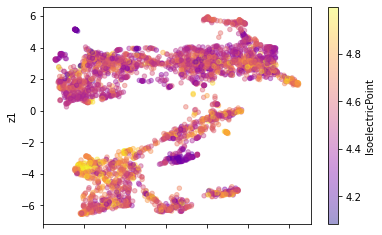

,z0,z1,IsoelectricPoint
0,3.685448,5.675566,4.596876
1,0.587249,-1.316251,4.789219
2,0.904962,-6.200028,4.565047
3,2.620651,3.205788,4.739144
4,-3.681179,-3.095888,4.639790
...,...,...,...
3651,-4.479226,-3.784634,4.721013
3652,0.045851,-1.712515,4.544016
3653,2.924804,-5.269952,4.650760
3654,-2.091721,2.751355,4.346103


In [36]:
key = "IsoelectricPoint"
iso_slice = (test_paint_df[key] < 5).values
plot_umap(test_umap[iso_slice], test_paint_df[key][iso_slice], key, cmap="plasma")

# Visualization of Validation Embeddings

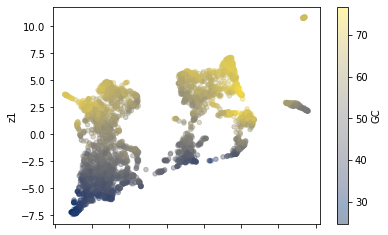

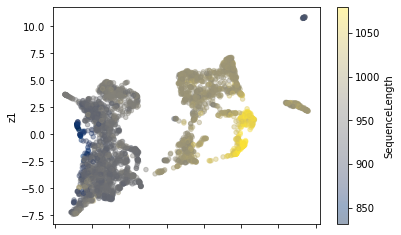

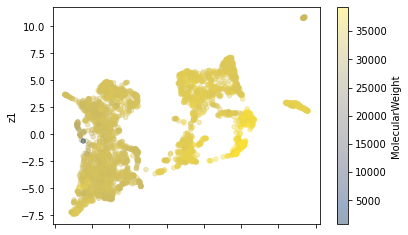

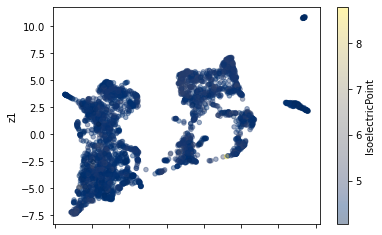

In [37]:
val_umap = run_umap(val_avg)
for key in val_paint_df:
    val_df = plot_umap(val_umap, val_paint_df[key], key, cmap="cividis")

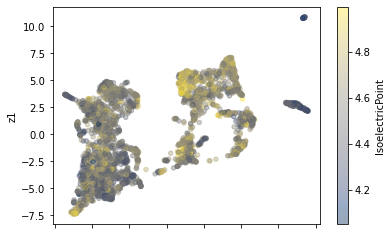

,z0,z1,IsoelectricPoint
0,-1.675152,-1.292830,4.677531
1,-3.036141,4.762235,4.678554
2,-2.647373,-3.773308,4.568286
3,-4.350834,-4.452694,4.621317
4,-2.466116,4.166238,4.671506
...,...,...,...
3659,0.810641,4.646047,4.857654
3660,-2.193107,3.920607,4.538105
3661,0.850491,5.604160,4.750796
3662,0.838490,3.862798,4.964738


In [38]:
key = "IsoelectricPoint"
iso_slice = (val_paint_df[key] < 5).values
plot_umap(val_umap[iso_slice], val_paint_df[key][iso_slice], key, cmap="cividis")